In [1]:
import sklearn
#import keras
import tensorflow as tf
from tensorflow import keras

import nltk
import pandas as pd
import numpy as np
import re
import codecs

from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [13]:
!pip install glove-python-binary

     |████████████████████████████████| 974 kB 13 kB/s eta 0:00:011


In [2]:
data = pd.read_csv("clean_data.csv")
data.tail()


,text,choose_one,class_label
10854,1 3 earthquake in 9km ssw of anza california ...,Relevant,1
10855,evacuation order lifted for town of roosevelt,Relevant,1
10856,see the 16yr old pkk suicide bomber who detona...,Relevant,1
10857,to conference attendees! the blue line from th...,Relevant,1
10858,the death toll in a is suicide car bombing on...,Relevant,1


In [3]:
data.groupby("choose_one").count()

,text,class_label
choose_one,,
Can't Decide,16,16
Not Relevant,6186,6186
Relevant,4657,4657


### Tokenization

In [4]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

data["tokens"] = data["text"].apply(tokenizer.tokenize)
data.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


### Bag of Words Counts

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = data["text"].tolist()
list_labels = data["class_label"].tolist()

data_counts, count_vectorizer = cv(list_corpus)

### Count vectorization

In [6]:
def plot_LSA(data, labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=10) # truncate data matrix to top k rank
        lsa.fit(data)
        lsa_scores = lsa.transform(data)
        color_mapper = {label:idx for idx,label in enumerate(set(labels))}
        color_column = [color_mapper[label] for label in labels]
        colors = ['red','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='red', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

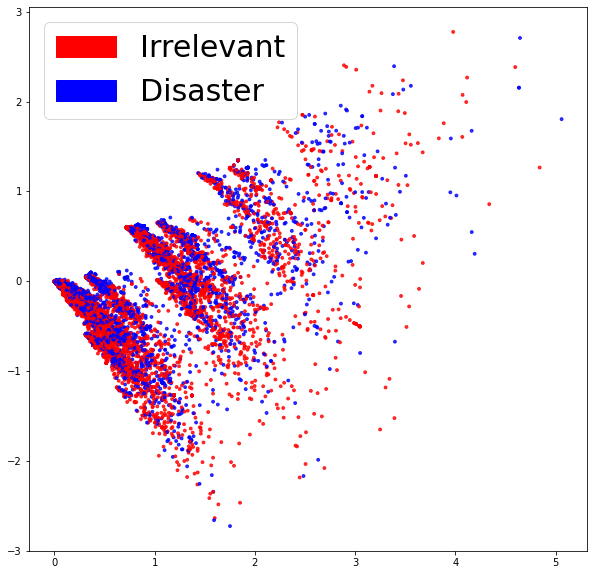

In [7]:
fig = plt.figure(figsize=(10, 10))
plot_LSA(data_counts, list_labels)
plt.show()

### TF-IDF

In [8]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

data_tfidf, tfidf_vectorizer = tfidf(list_corpus)

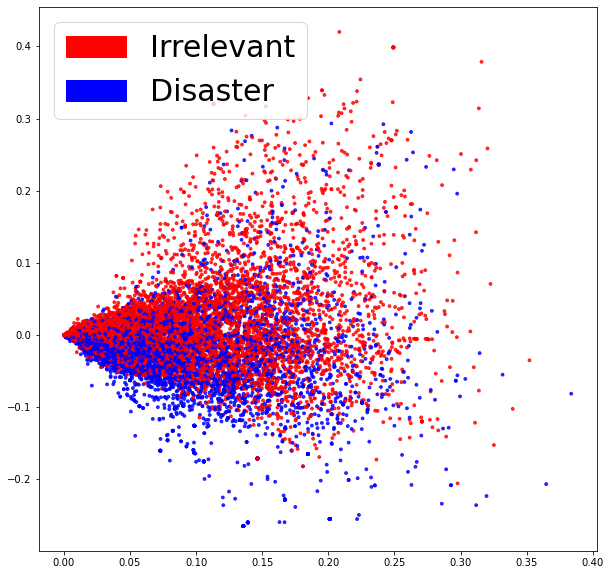

In [9]:
fig = plt.figure(figsize=(10, 10))
plot_LSA(data_tfidf, list_labels)
plt.show()

### Standford Word2Vec

You can download the GloVe vectors from [the Glove page](https://nlp.stanford.edu/projects/glove/). or from [this zip file](https://nlp.stanford.edu/data/glove.6B.zip)

In [28]:
import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [11]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=100):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
        
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged


def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [12]:
# adjust the path relative to your glove file
glove_file = datapath('/Users/ndah/Desktop/NLP_course_notes/glove.6B/glove.6B.100d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.100d.word2vec.txt")

glove2word2vec(glove_file, word2vec_glove_file)
word2vec = KeyedVectors.load_word2vec_format(word2vec_glove_file)

<ipython-input-12-8636ff16e77c>:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)


In [13]:
embeddings = get_word2vec_embeddings(word2vec, data)

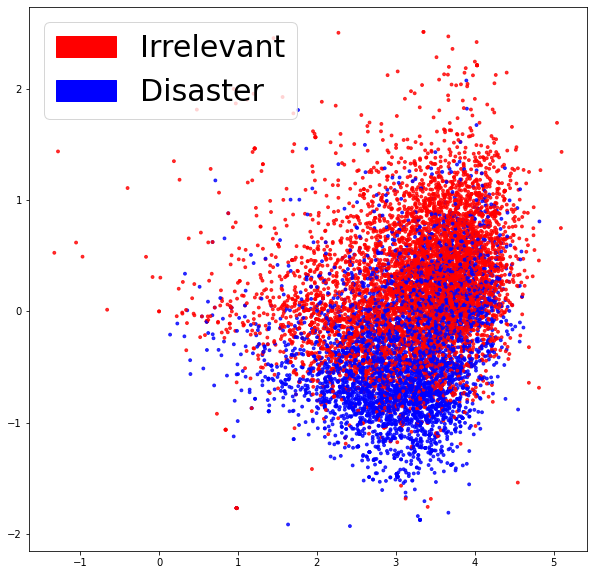

In [14]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels)
plt.show()

### Gensim visualization

In [15]:
def analogy(x1, x2, y1):
    result = word2vec.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]


def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            #words = np.random.choice(list(model.vocab.keys()), sample)
            words = np.random.choice(list(model.wv.index_to_key), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [16]:
print ("# of words", len(word2vec.key_to_index))

# of words 400000


In [17]:
word2vec.most_similar('banana')

[('coconut', 0.7097253799438477),
 ('mango', 0.705482542514801),
 ('bananas', 0.6887733936309814),
 ('potato', 0.6629636287689209),
 ('pineapple', 0.6534532308578491),
 ('fruit', 0.6519855260848999),
 ('peanut', 0.6420576572418213),
 ('pecan', 0.6349173188209534),
 ('cashew', 0.6294420957565308),
 ('papaya', 0.6246591210365295)]

In [18]:
word2vec.most_similar(negative='banana')

[('keyrates', 0.7173938751220703),
 ('sungrebe', 0.7119238972663879),
 ('þórður', 0.7067720293998718),
 ('zety', 0.7056615948677063),
 ('23aou94', 0.6959497928619385),
 ('___________________________________________________________',
  0.694915235042572),
 ('elymians', 0.6945434212684631),
 ('camarina', 0.6927202343940735),
 ('ryryryryryry', 0.6905654072761536),
 ('maurilio', 0.6865653395652771)]

In [19]:
analogy('ghana', 'ghanian', 'senegal')

'senegalese'

In [20]:
analogy('good', 'fantastic', 'bad')

'terrible'

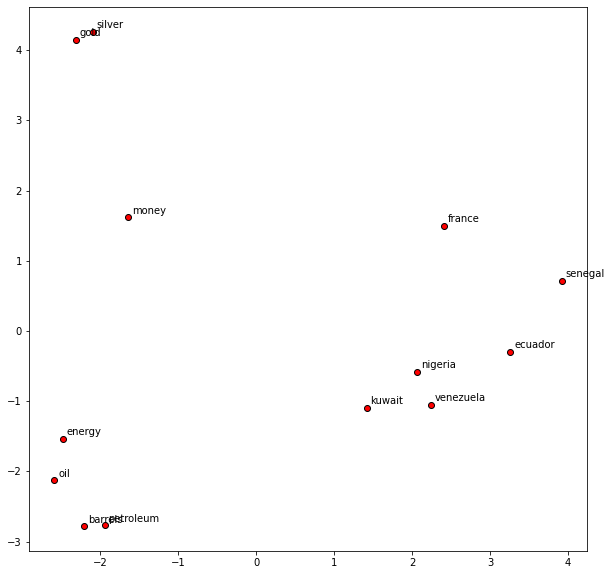

In [21]:
words = ['barrels', 'silver', 'ecuador', 'energy', 'kuwait', 'money', 'oil', 'gold', 'petroleum', 'venezuela', 'nigeria', 'senegal', 'france']
display_pca_scatterplot(word2vec, words)

In [22]:
# calculate: woman + (king - man) = ?
result = word2vec.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)
print(result)

[('queen', 0.7698541283607483), ('monarch', 0.6843380928039551), ('throne', 0.6755736470222473), ('daughter', 0.6594556570053101), ('princess', 0.6520534157752991), ('prince', 0.6517035365104675), ('elizabeth', 0.6464517712593079), ('mother', 0.6311717629432678), ('emperor', 0.6106470823287964), ('wife', 0.6098655462265015)]


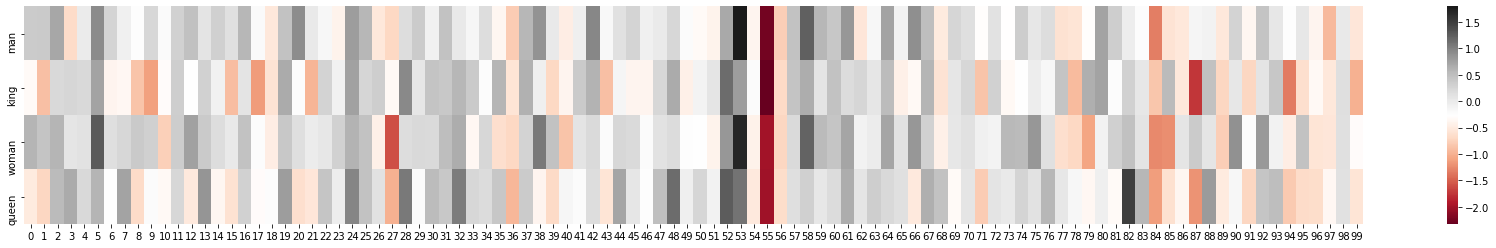

In [23]:
plt.figure(figsize=(30,4))
df = pd.DataFrame({'man': word2vec['man'],
                   'king': word2vec['king'],
                   'woman': word2vec['woman'],
                   'queen': word2vec['queen']
                  })
sns.heatmap(df.T, fmt="g", cmap='RdGy')
plt.show()

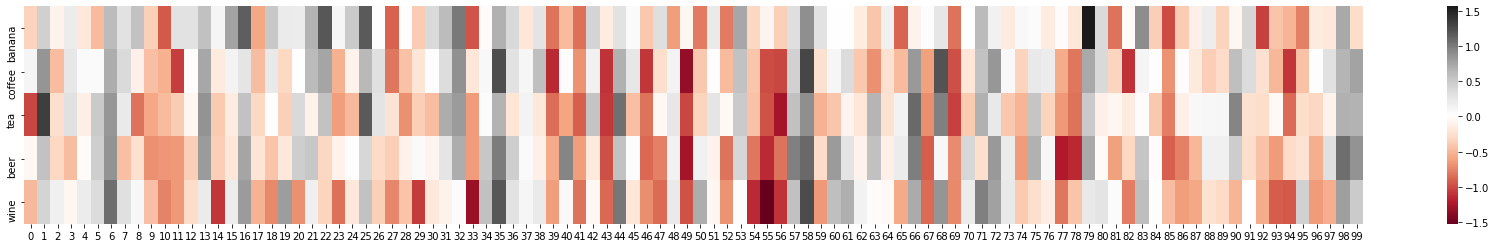

In [24]:
plt.figure(figsize=(30,4))
df = pd.DataFrame({'banana': word2vec['banana'],
                   'coffee': word2vec['coffee'],
                   'tea': word2vec['tea'],
                   'beer': word2vec['beer'],
                   'wine': word2vec['wine'],
                  })
sns.heatmap(df.T, fmt="g", cmap='RdGy')
plt.show()

why do we have a fairly high similarity between logitec and cat, or steel and cloths, or ipod and banana? while there is a very low similarity between ipod and steel and logitech and cloth

In [25]:
print('logitech', '/', 'cat', '->', word2vec.similarity('logitech', 'cat'))
print('steel', '/', 'cloth', '->', word2vec.similarity('steel', 'cloth'))
print('ipod', '/', 'banana', '->', word2vec.similarity('ipod', 'banana'))

logitech / cat -> 0.26268926
steel / cloth -> 0.42388725
ipod / banana -> 0.2435296


In [26]:
print ('ipod', '/', 'steel', '->', word2vec.similarity('ipod', 'steel'))
print ('logitech', '/', 'cloth', '->', word2vec.similarity('logitech', 'cloth'))

ipod / steel -> 0.054595962
logitech / cloth -> -0.0063639972
